# Econ 212: Homework 2

In [110]:
from fredapi import Fred
from scipy.optimize import fsolve
from sequence_jacobian import simple, create_model, solved
from sequence_jacobian.utilities.drawdag import drawdag
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.filters.hp_filter import hpfilter

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(12345)

In [111]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')

## Question 1: Government Spending Shocks



### Part 3: Model calibration and simulation

In [112]:
Y_data = fred.get_series('GDPC1')
G_data = fred.get_series('GCEC1')

G_filter = hpfilter(np.log(G_data) * 100, lamb = 1600)[0]

print(f"G / Y: ", np.mean(G_data / Y_data))

G / Y:  0.258953545842333


In [113]:
gt_1 = np.array(G_filter[:-1]).reshape((-1, 1))
gt = np.array(G_filter[1:])
ar1 = LinearRegression().fit(gt_1, gt)

print(f"rho_g: {ar1.coef_}")

rho_g: [0.8965829]


In [114]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, b, delta):
    C = (w / b / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta, G):
    goods_mkt = Y - C - I - G
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L
    return goods_mkt, euler, walras

@simple
def calibration_block(K, Y, L, I):
    ky_ratio = K/Y - 14
    iy_ratio = I/Y - 0.25
    l_fixed = L - 1/3
    return ky_ratio,  iy_ratio, l_fixed

In [115]:
alpha = 0.33
beta = 0.99
eta = 1.
delta = 1./56.
b = 6.5746
rho = 0.979
rho_g = 0.9

sigma = 0.01
sigma_g = 0.01

Frisch = 1./eta
EIS = 0.5

T = 250

In [116]:
rbc_1 = create_model([household, firm, mkt_clearing, calibration_block], name = "RBC_1")

calibration = {"Z": 1., "eis": EIS, "frisch": Frisch, "alpha": alpha, "G": 0.26}
unknowns_ss = {"b": b, "K": 20., "L" : 0.33, "delta" : delta, "beta" : beta}
targets_ss = {"goods_mkt": 0., "euler": 0. , "ky_ratio" : 0,  "iy_ratio" : 0,  "l_fixed" : 0}

ss_1 = rbc_1.solve_steady_state(calibration, unknowns_ss, targets_ss, solver = "hybr")

inputs_1 = {"Z", "G"}
unknowns_1 = {"K", "L"}
targets_1 = {"goods_mkt", "euler"}

G_1 = rbc_1.solve_jacobian(ss_1, unknowns_1, targets_1, inputs_1, T = T)

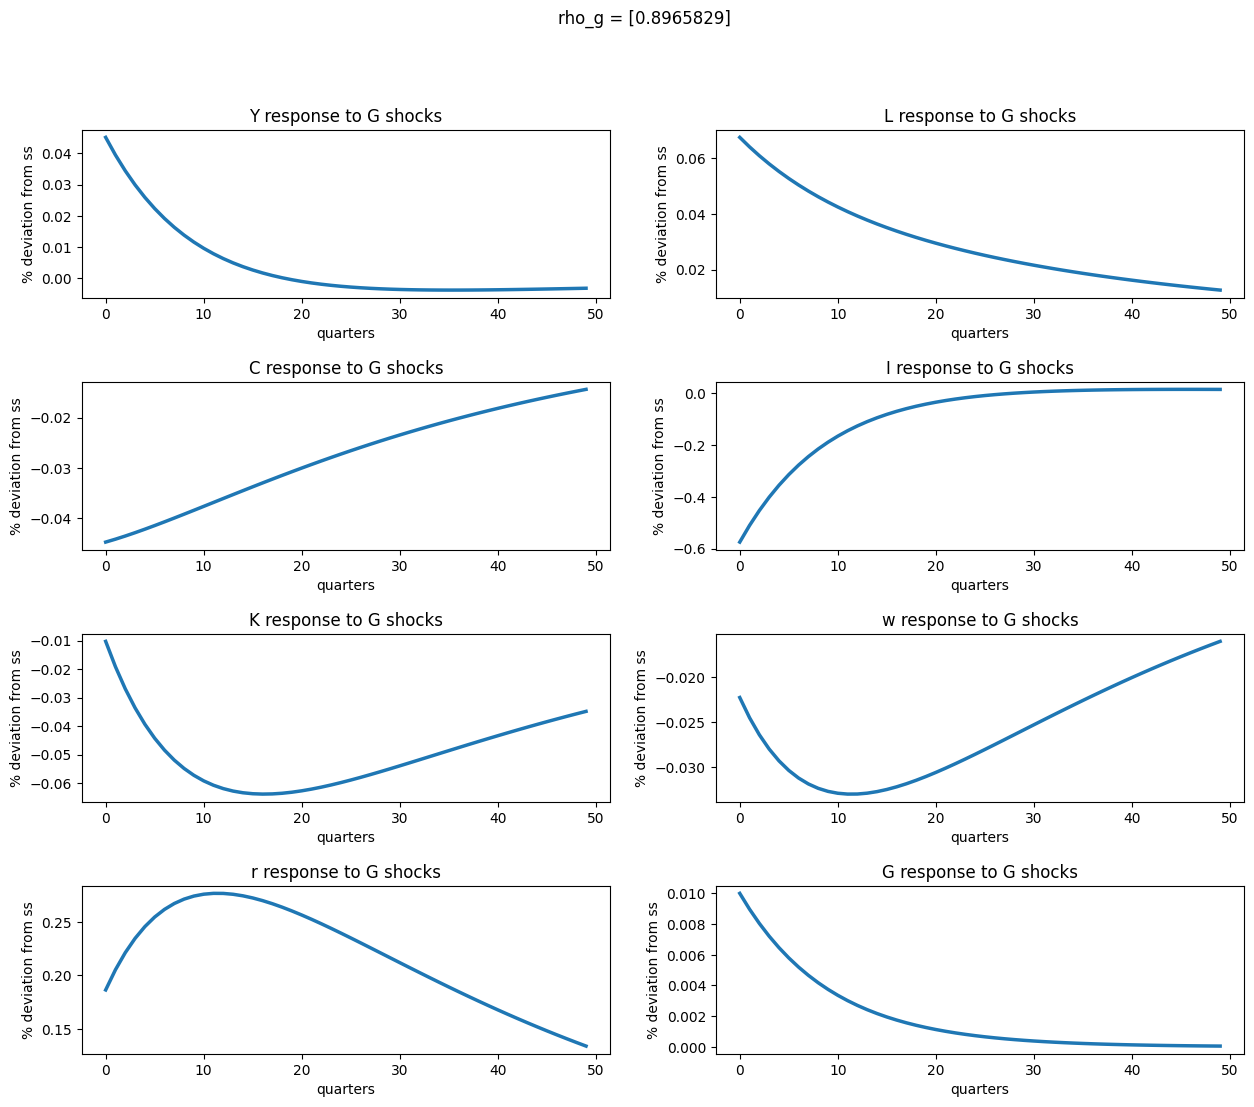

In [117]:
VAR_LIST = ["Y", "L", "C", "I", "K", "w", "r"]
rho_g = ar1.coef_

da = np.exp(sigma_g * ss_1['G'] * rho_g**np.arange(T)) - 1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)


for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_1[var]['G'] @ da / ss_1[var]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(dVal[:50], linewidth=2.5)
    ax.set_title(f'{var} response to G shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

# Generate impulse response for G given it is AR(1)
g_response = [sigma_g * rho_g**t for t in range(50)]

ax = plt.subplot(4, 2, len(VAR_LIST) + 1)
ax.plot(g_response, linewidth=2.5)
ax.set_title(f'G response to G shocks')
ax.set_ylabel('% deviation from ss')
ax.set_xlabel('quarters')

plt.suptitle(f"rho_g = {rho_g}")
plt.show()

In [118]:
print(G_1)

<JacobianDict outputs=['L', 'K', 'C', 'I', 'r', 'w', 'Y', 'goods_mkt', 'euler', 'walras', 'ky_ratio', 'iy_ratio', 'l_fixed'], inputs=['G', 'Z']>


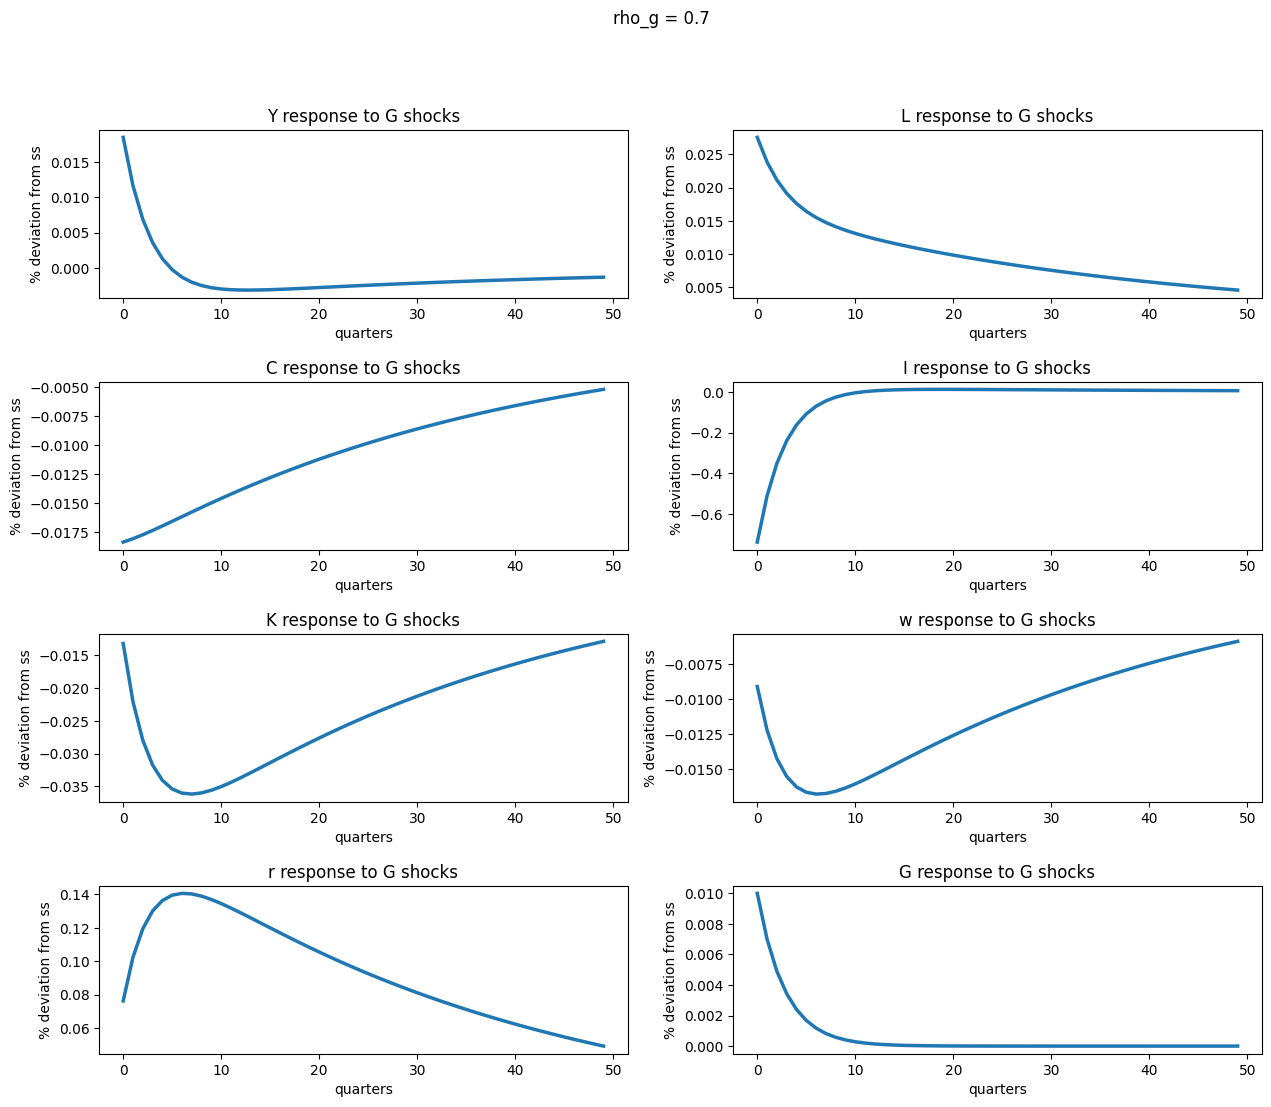

In [119]:
rho_g = 0.7
da = np.exp(sigma_g * ss_1['G'] * rho_g**np.arange(T)) - 1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)


for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_1[var]['G'] @ da / ss_1[var]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(dVal[:50], linewidth=2.5)
    ax.set_title(f'{var} response to G shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')


# Generate impulse response for G given it is AR(1)
g_response = [sigma_g * rho_g**t for t in range(50)]

ax = plt.subplot(4, 2, len(VAR_LIST) + 1)
ax.plot(g_response, linewidth=2.5)
ax.set_title(f'G response to G shocks')
ax.set_ylabel('% deviation from ss')
ax.set_xlabel('quarters')

plt.suptitle(f"rho_g = {rho_g}")
plt.show()

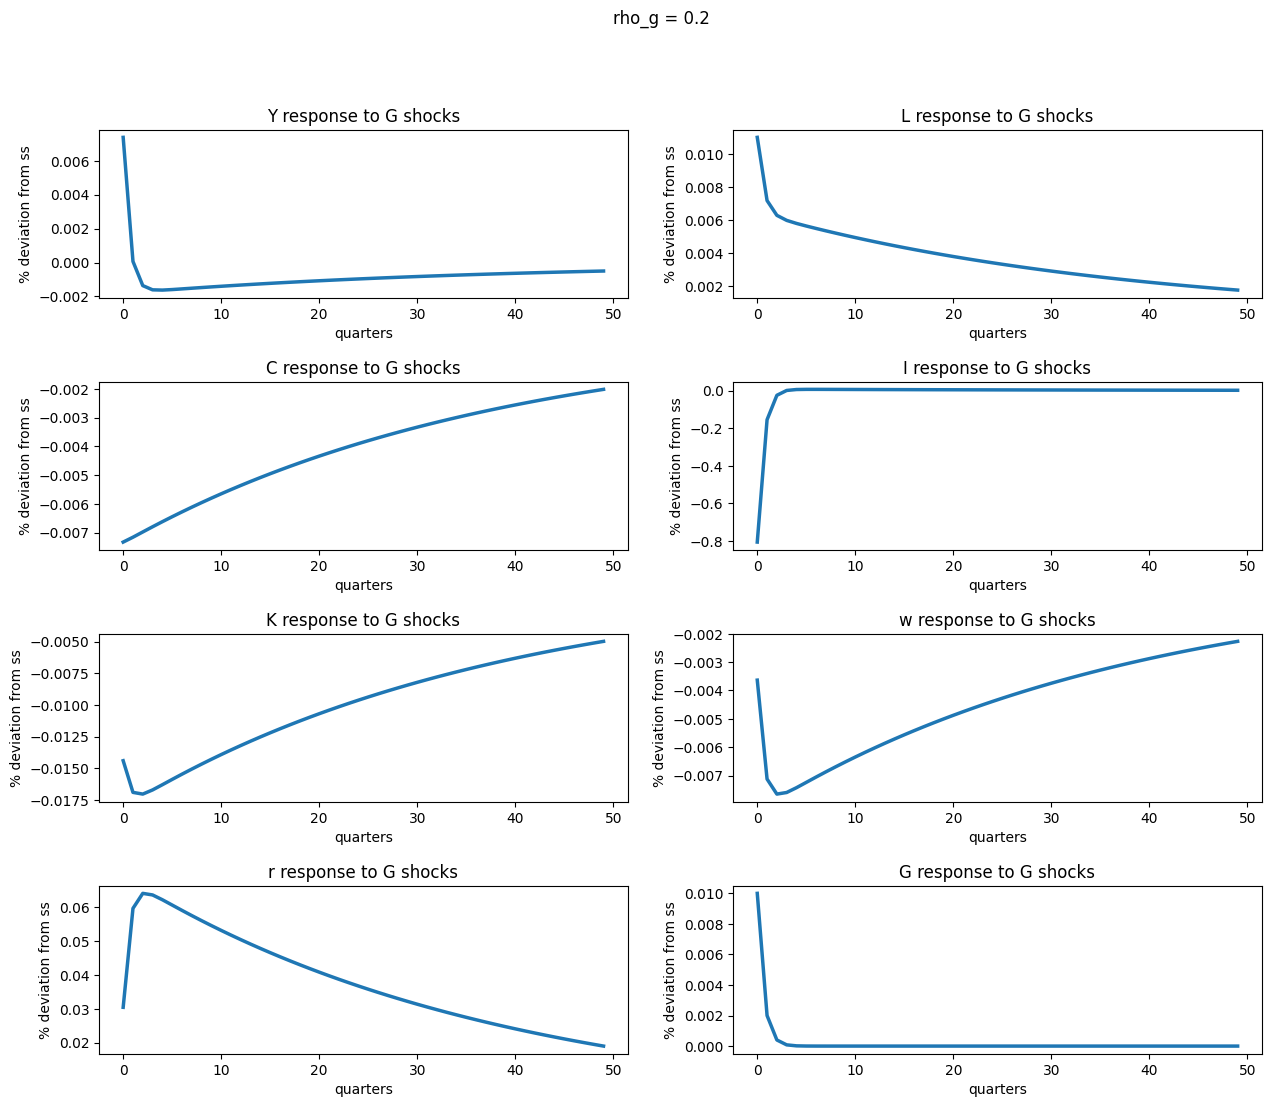

In [120]:
rho_g = 0.2
da = np.exp(sigma_g * ss_1['G'] * rho_g**np.arange(T)) - 1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)


for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_1[var]['G'] @ da / ss_1[var]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(dVal[:50], linewidth=2.5)
    ax.set_title(f'{var} response to G shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

# Generate impulse response for G given it is AR(1)
g_response = [sigma_g * rho_g**t for t in range(50)]

ax = plt.subplot(4, 2, len(VAR_LIST) + 1)
ax.plot(g_response, linewidth=2.5)
ax.set_title(f'G response to G shocks')
ax.set_ylabel('% deviation from ss')
ax.set_xlabel('quarters')

plt.suptitle(f"rho_g = {rho_g}")
plt.show()

In [121]:
PERIODS = 200
BURN = 50
IMPACT_Z = 0.01
IMPACT_G = 0.01
RHO_G = ar1.coef_
RHO_Z = 0.9
MU_G = np.exp((1-RHO_G)*np.log(0.26*ss_1['Y']))



In [145]:
epsilon_z_shocks = np.random.normal(0, sigma, size=PERIODS)
epsilon_g_shocks = np.random.normal(0, sigma_g, size=PERIODS)

dlZ = np.zeros((PERIODS + 1, 1))
dZ = np.zeros((PERIODS + 1, 1))

dlG = np.zeros((PERIODS + 1, 1))
dG = np.zeros((PERIODS + 1, 1))

for t in range(PERIODS):
    dlZ[t + 1] = RHO_Z * dlZ[t] + epsilon_z_shocks[t]
    dlG[t + 1] = RHO_G * dlG[t] + epsilon_g_shocks[t] + np.exp(np.log(0.26 * ss_1['Y']) * (1 - RHO_G))

dZ = np.exp(dlZ[1:]) - ss_1['Z']
dG = np.exp(dlG[1:]) - ss_1['G']

dZ_mat = np.zeros((PERIODS, PERIODS))
dG_mat = np.zeros((PERIODS, PERIODS))
for t in range(PERIODS):
    dZ_mat[t:, t] = epsilon_z_shocks[t] * RHO_Z**np.arange(PERIODS - t)
    dG_mat[t:, t] = epsilon_g_shocks[t] * RHO_G**np.arange(PERIODS - t)

sims = {}
for var in VAR_LIST:
    sim_matrix = np.zeros((PERIODS,))
    for t in range(PERIODS):
        sim_matrix[t:] += G_1[var]['Z'][:PERIODS - t, :PERIODS - t] @ dZ_mat[t:, t]
        sim_matrix[t:] += G_1[var]['G'][:PERIODS - t, :PERIODS - t] @ dG_mat[t:, t]
    sim_matrix += ss_1[var]
    sims[var] = sim_matrix
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(sims[var][50:], label=f'{var}', linewidth=2.5,)
    ax.plot(hpfilter(sims[var][50:], 1600)[1], label = "HP")

    ax.set_title(f'Simulated {var}')
    ax.set_ylabel(f'{var} level')
    ax.set_xlabel('quarters')

    # Add a horizontal line at SS
    ax.axhline(ss_1[var], color='r', linestyle='--', linewidth=1.5)


Now we try just the Z shocks

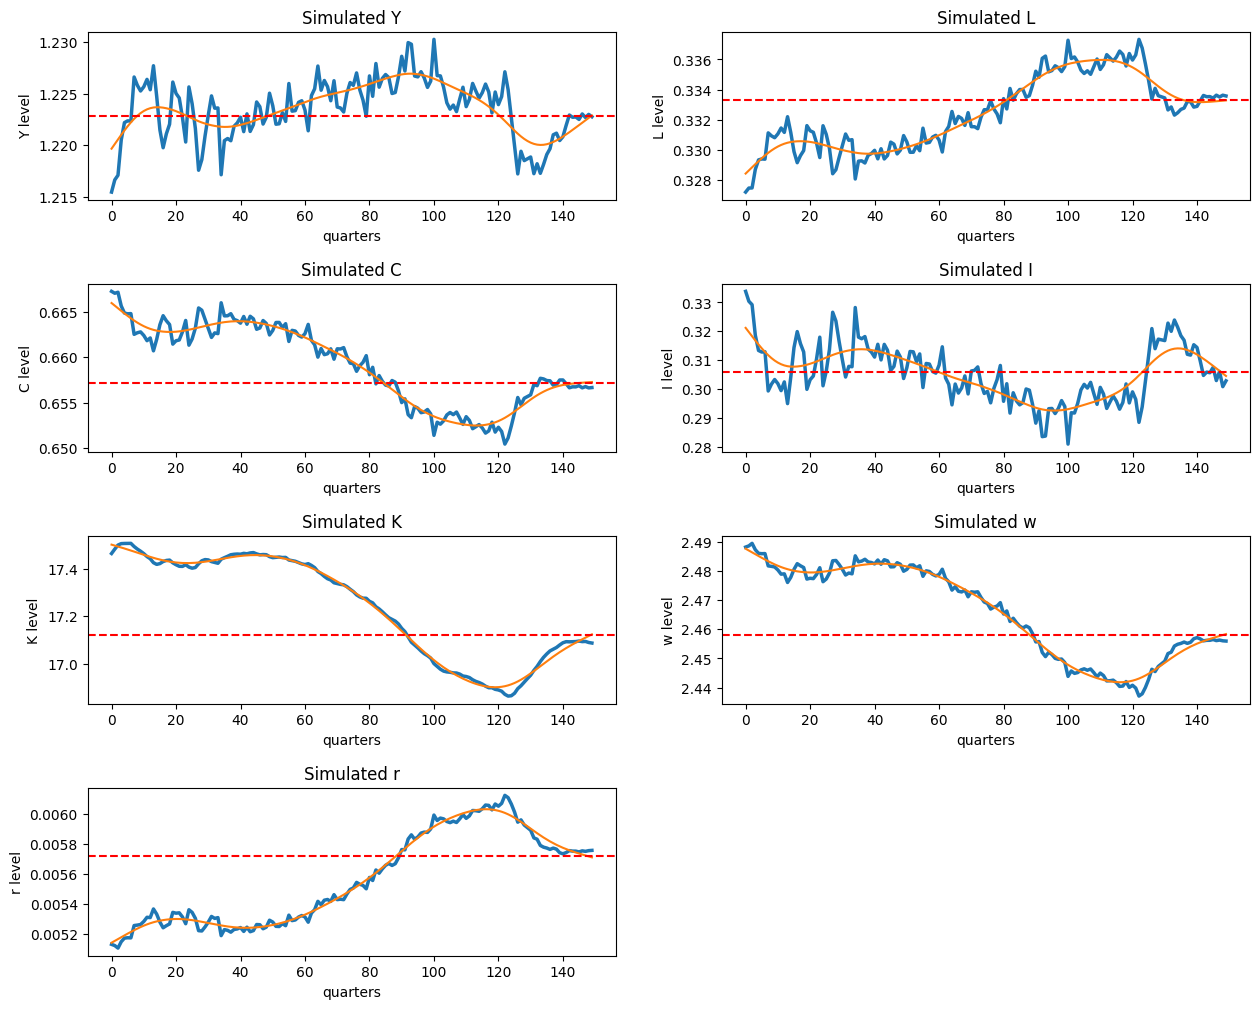

In [156]:
epsilon_z_shocks = np.zeros((PERIODS, 1))
epsilon_g_shocks = np.random.normal(0, sigma_g, size=PERIODS)

dlZ = np.zeros((PERIODS + 1, 1))
dZ = np.zeros((PERIODS + 1, 1))

dlG = np.zeros((PERIODS + 1, 1))
dG = np.zeros((PERIODS + 1, 1))

for t in range(PERIODS):
    dlZ[t + 1] = RHO_Z * dlZ[t] + epsilon_z_shocks[t]
    dlG[t + 1] = RHO_G * dlG[t] + epsilon_g_shocks[t] + np.exp(np.log(0.26 * ss_1['Y']) * (1 - RHO_G))

dZ = np.exp(dlZ[1:]) - ss_1['Z']
dG = np.exp(dlG[1:]) - ss_1['G']

dZ_mat = np.zeros((PERIODS, PERIODS))
dG_mat = np.zeros((PERIODS, PERIODS))
for t in range(PERIODS):
    dZ_mat[t:, t] = epsilon_z_shocks[t] * RHO_Z**np.arange(PERIODS - t)
    dG_mat[t:, t] = epsilon_g_shocks[t] * RHO_G**np.arange(PERIODS - t)

sims = {}
for var in VAR_LIST:
    sim_matrix = np.zeros((PERIODS,))
    for t in range(PERIODS):
        sim_matrix[t:] += G_1[var]['Z'][:PERIODS - t, :PERIODS - t] @ dZ_mat[t:, t]
        sim_matrix[t:] += G_1[var]['G'][:PERIODS - t, :PERIODS - t] @ dG_mat[t:, t]
    sim_matrix += ss_1[var]
    sims[var] = sim_matrix
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(sims[var][50:], label=f'{var}', linewidth=2.5,)
    ax.plot(hpfilter(sims[var][50:], 1600)[1], label = "HP")

    ax.set_title(f'Simulated {var}')
    ax.set_ylabel(f'{var} level')
    ax.set_xlabel('quarters')

    # Add a horizontal line at SS
    ax.axhline(ss_1[var], color='r', linestyle='--', linewidth=1.5)

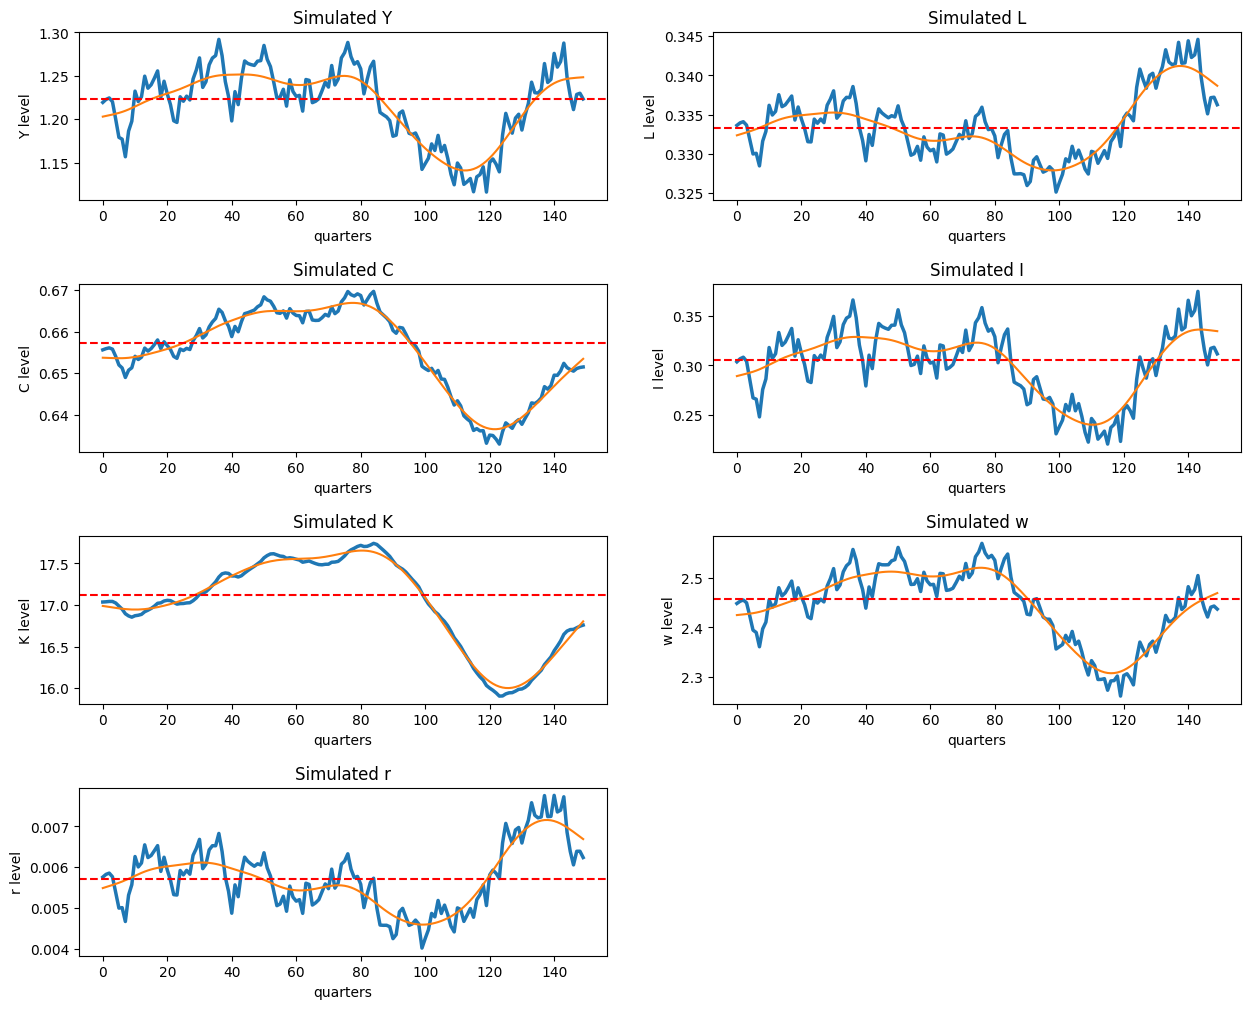

In [157]:
epsilon_z_shocks = np.random.normal(0, sigma, size=PERIODS)
epsilon_g_shocks = np.zeros((PERIODS, 1))

dlZ = np.zeros((PERIODS + 1, 1))
dZ = np.zeros((PERIODS + 1, 1))

dlG = np.zeros((PERIODS + 1, 1))
dG = np.zeros((PERIODS + 1, 1))

for t in range(PERIODS):
    dlZ[t + 1] = RHO_Z * dlZ[t] + epsilon_z_shocks[t]
    dlG[t + 1] = RHO_G * dlG[t] + epsilon_g_shocks[t] + np.exp(np.log(0.26 * ss_1['Y']) * (1 - RHO_G))

dZ = np.exp(dlZ[1:]) - ss_1['Z']
dG = np.exp(dlG[1:]) - ss_1['G']

dZ_mat = np.zeros((PERIODS, PERIODS))
dG_mat = np.zeros((PERIODS, PERIODS))
for t in range(PERIODS):
    dZ_mat[t:, t] = epsilon_z_shocks[t] * RHO_Z**np.arange(PERIODS - t)
    dG_mat[t:, t] = epsilon_g_shocks[t] * RHO_G**np.arange(PERIODS - t)

sims = {}
for var in VAR_LIST:
    sim_matrix = np.zeros((PERIODS,))
    for t in range(PERIODS):
        sim_matrix[t:] += G_1[var]['Z'][:PERIODS - t, :PERIODS - t] @ dZ_mat[t:, t]
        sim_matrix[t:] += G_1[var]['G'][:PERIODS - t, :PERIODS - t] @ dG_mat[t:, t]
    sim_matrix += ss_1[var]
    sims[var] = sim_matrix
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    
    ax = plt.subplot(4, 2, i + 1)

    ax.plot(sims[var][50:], label=f'{var}', linewidth=2.5,)
    ax.plot(hpfilter(sims[var][50:], 1600)[1], label = "HP")

    ax.set_title(f'Simulated {var}')
    ax.set_ylabel(f'{var} level')
    ax.set_xlabel('quarters')

    # Add a horizontal line at SS
    ax.axhline(ss_1[var], color='r', linestyle='--', linewidth=1.5)

Now we can add the simulated moments

## Question 2: Productivity News Shocks

### Part 1b: Impulse Response Functions, Baseline

In [ ]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, b, delta):
    C = (w / b / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L
    return goods_mkt, euler, walras

@simple
def Z_process(Z, epsilon, epsilon_news, rho):
    epsilon_end = (Z).apply(np.log) - rho * (Z(-1)).apply(np.log) - epsilon_news(-4)
    epsilon_target = epsilon_end - epsilon
    return epsilon_target 

In [ ]:
alpha = 0.33
beta = 0.99
eta = 1.
delta = 0.02
b = 6.57
sigma = 0.01
rho = 0.9

Frisch = 1./eta
EIS = 1.

T = 250

In [ ]:
rbc_1b = create_model([household, firm, mkt_clearing, Z_process], name="RBC_2_1b")

calibration = {"Z": 1., "eis": EIS, "frisch": Frisch, "alpha": 0.33,"epsilon": 0., "epsilon_news": 0., "rho": rho, "delta" : 0.02, "b": b, "beta" : 0.99}
unknowns_ss = {"K": 20., "L" : 0.33}
targets_ss = {"goods_mkt": 0., "euler": 0.}

ss_1b = rbc_1b.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

inputs_1b = {"epsilon", "epsilon_news"}
unknowns_1b = {"K","L","Z"}
targets_1b = {"goods_mkt","euler","epsilon_target"}

G_1b = rbc_1b.solve_jacobian(ss_1b, unknowns_1b, targets_1b, inputs_1b, T=T)

In [ ]:
VAR_LIST = ["Y", "L", "C", "I"]

In [ ]:
deps_news = np.zeros(T)
deps_news[0] = sigma

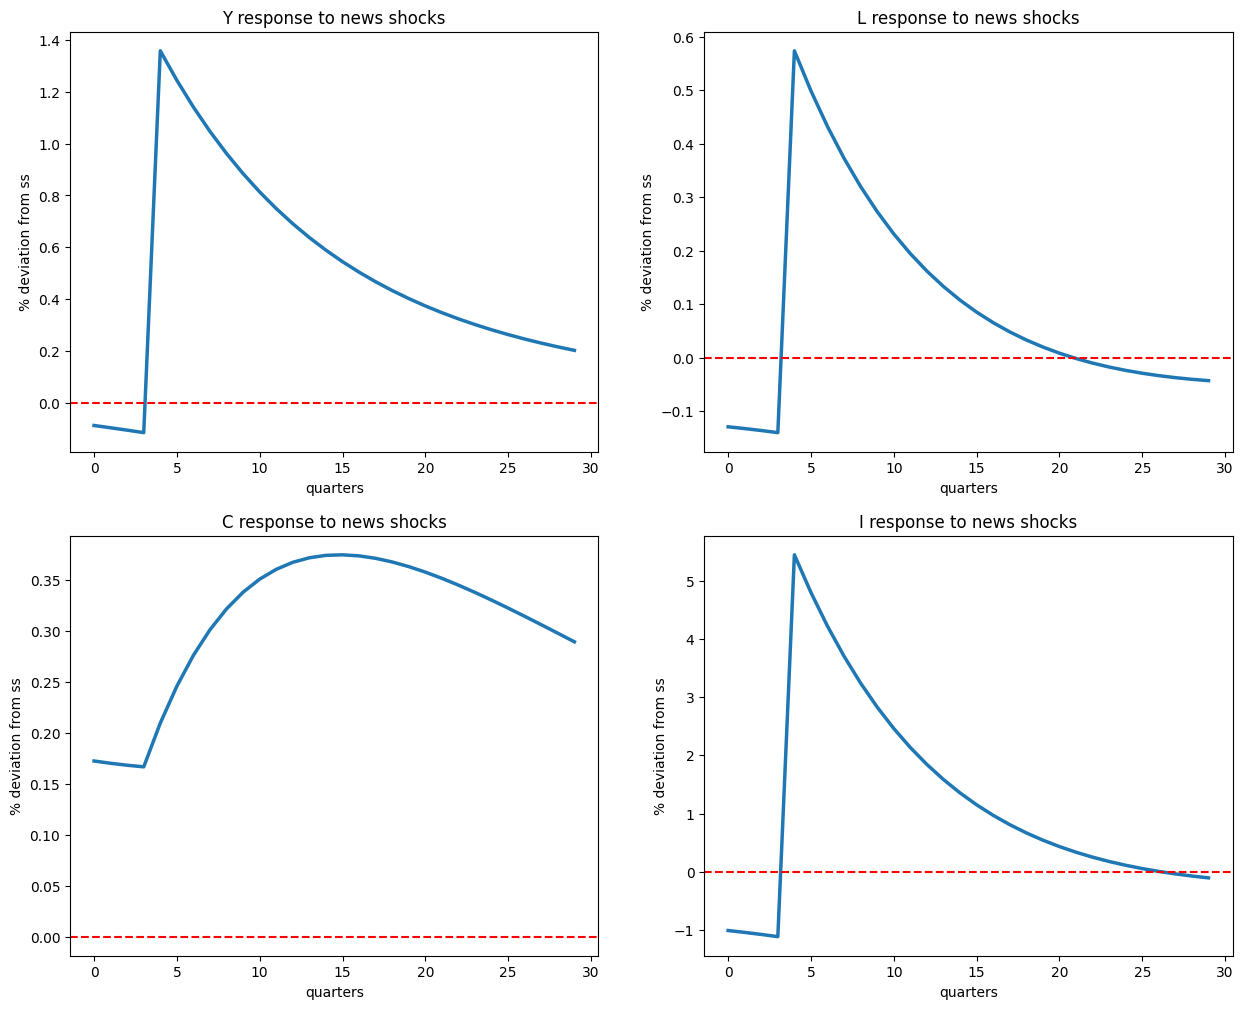

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_1b[var]['epsilon_news'] @ deps_news / ss_1b[var]
    
    ax = plt.subplot(2, 2, i + 1)

    ax.plot(dVal[:30], linewidth=2.5)
    ax.axhline(y = 0, linestyle = "--", color = "r")
    ax.set_title(f'{var} response to news shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

plt.show()

### Part 2b: Impulse Response Functions, Habit Formation

In [ ]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household_consumption(b, L, w, eta):
    lamb = b * L**eta / w
    return lamb
    
@simple
def mkt_clearing(C, K, I, Y, q, r, beta, lamb, delta, kappa, phi):
    goods_mkt = Y - C - I
    q_eq = 1 / (1 - phi * (I / K(-1) - delta)) - q
    euler = (beta * lamb(+1) / lamb * ((r(+1) + delta) + q(+1) * (1 - delta + phi * (I(+1) / K - delta) * (I(+1) / K) - (phi / 2) * (I(+1) / K - delta)**2))) / q - 1
    C_eq = 1 / (C - kappa * C(-1)) - beta * kappa / (C(+1) - kappa * C) - lamb
    I_eq = (1 - delta) * K(-1) + I - (phi / 2) * ((I / K(-1) - delta) ** 2) * K(-1) - K
    return goods_mkt, euler, q_eq, C_eq, I_eq

@simple
def Z_process(Z, epsilon, epsilon_news, rho):
    epsilon_end = (Z).apply(np.log) - rho * (Z(-1)).apply(np.log) - epsilon_news(-4)
    epsilon_target = epsilon_end - epsilon
    return  epsilon_target 

In [ ]:
kappa = 0.75
phi = 1.

In [ ]:
rbc_2b = create_model([household_consumption, firm, mkt_clearing, Z_process], name="RBC_2_2b")

calibration = {"alpha": alpha, "beta": beta, "delta": delta, "epsilon": 0., "epsilon_news": 0., "eta": eta, 
               "kappa": kappa, "phi": phi, "rho": rho, "b": b, "Z": 1.}
unknowns_ss = {"K": 20., "L" : 1., "C": 1., "I": 0.5, "q": 1.}
targets_ss = {"goods_mkt": 0., "euler": 0., "q_eq": 0., "C_eq": 0., "I_eq": 0.}

ss_2b = rbc_2b.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

inputs_2b = {"epsilon", "epsilon_news"}
unknowns_2b = {"K", "L", "Z", "C", "I", "q"}
targets_2b = {"epsilon_target", "goods_mkt", "euler", "q_eq", "C_eq", "I_eq"}

G_2b = rbc_2b.solve_jacobian(ss_2b, unknowns_2b, targets_2b, inputs_2b, T=T)

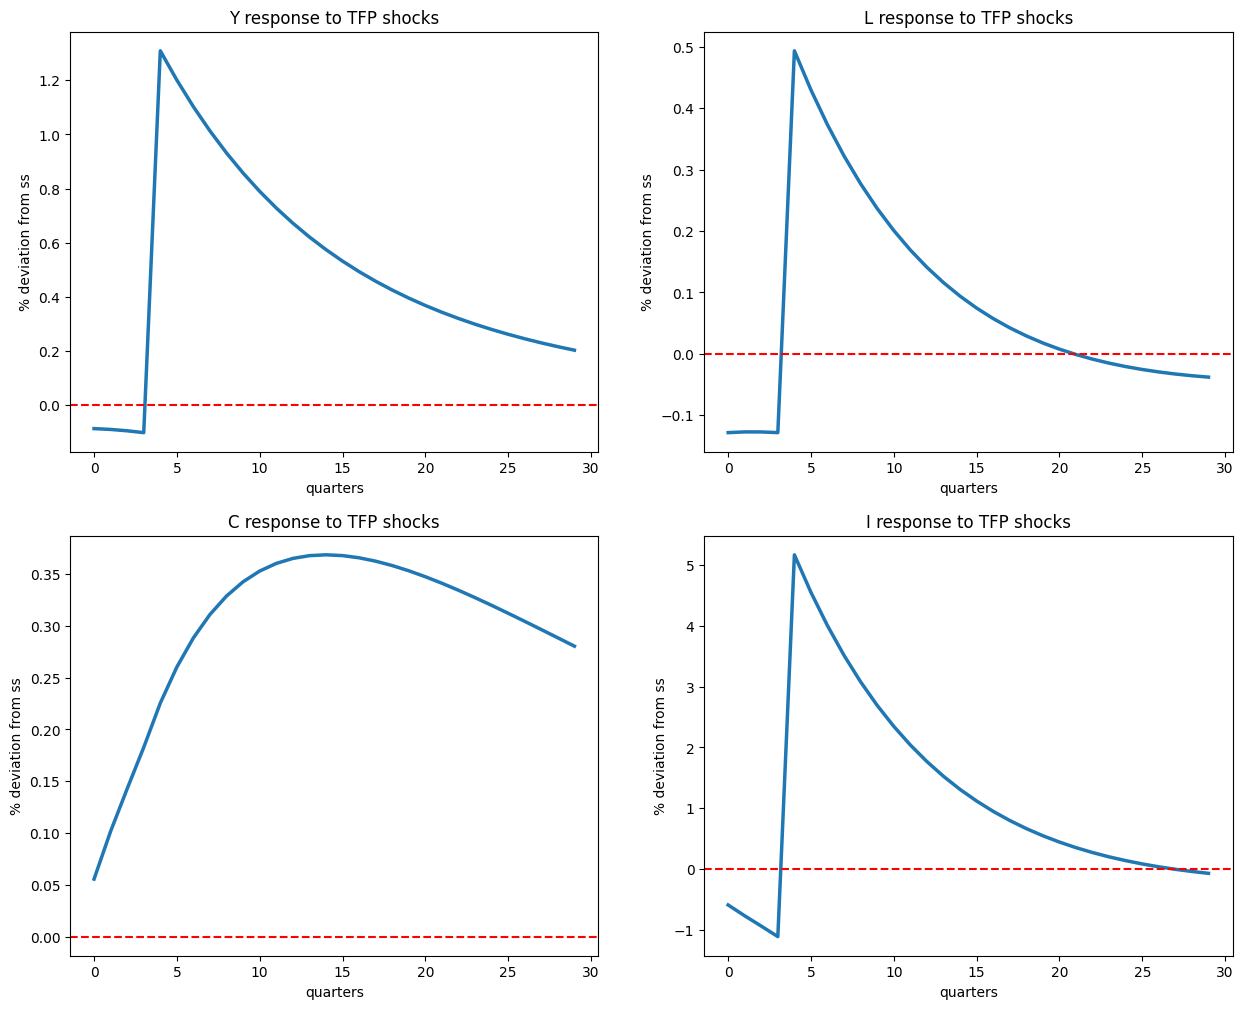

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_2b[var]['epsilon_news'] @ deps_news / ss_2b[var]
    
    ax = plt.subplot(2, 2, i + 1)

    ax.plot(dVal[:30], linewidth=2.5)
    ax.axhline(y = 0, linestyle = "--", color = "r")
    ax.set_title(f'{var} response to TFP shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

plt.show()

### Part 3b: Impulse Response Functions, Investment Growth Rate

In [ ]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@solved(unknowns={'I': (-5, 5)}, targets = ['I_eq'])
def household_invest(K, I, phi, delta):
    I_eq = (1-delta)*K(-1) + I - (phi/2) * ((I/I(-1) - 1) ** 2) * I - K
    return I_eq

@solved(unknowns={'mu': (-5, 5)}, targets = ['mu_eq'])
def mu_solve(C, L, K, Z, alpha, beta, delta, kappa, mu):
    lambda_t = 1/(C - kappa*C(-1)) - beta*kappa/(C(+1) - kappa*C)
    r_t = alpha * Z * (K(-1) ** (alpha - 1)) * (L ** (1-alpha))
    mu_eq = beta * (lambda_t * r_t + mu * (1 - delta)) - mu(-1)
    return mu_eq

@simple
def household_consumption(C, K, I, Z, L, kappa, beta, phi, delta, alpha, eta, b, mu):
    lambda_t = 1/(C - kappa*C(-1)) - beta*kappa/(C(+1) - kappa*C)
    
    # intertemporal
    C_eq1 = beta * mu(+1) * phi * (I(+1) / I - 1) * (I(+1) / I)**2
    C_eq2 = lambda_t - mu * (1 - (phi / 2) * (I / I(-1) - 1)**2 - phi * (I / I(-1) - 1) * (I / I(-1)))
    C_eq = C_eq1 - C_eq2
    
    # intratemporal
    w_t = (1 - alpha) * Z * (K(-1) ** (alpha)) * (L ** (-alpha))
    n_eq = b * L**eta - lambda_t * w_t
    
    return C_eq, n_eq
    
@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    walras = C + K - (1 + r) * K(-1) - w * L
    return goods_mkt, walras

@simple
def Z_process(Z, epsilon, epsilon_news, rho):
    epsilon_end = (Z).apply(np.log) - rho * (Z(-1)).apply(np.log) - epsilon_news(-4)
    epsilon_target = epsilon_end - epsilon
    return  epsilon_target 

In [ ]:
rbc_3b = create_model([household_invest, household_consumption, mu_solve, firm, mkt_clearing, Z_process], 
                      name="RBC_2_3b")

calibration = {"Z": 1., "eis": EIS, "frisch": Frisch, "alpha": 0.33, "epsilon": 0., "epsilon_news": 0., "rho": rho, 
               "delta" : 0.02, "b": b, "beta" : 0.99, "phi": phi, "kappa": kappa, "eta": eta}
unknowns_ss = {"K": 10., "L" : 0.33, "C": 1., "Y": .5}
targets_ss = {"goods_mkt": 0., "walras": 0., "C_eq": 0., "n_eq": 0.}

ss_3b = rbc_3b.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

inputs_3b = {"epsilon", "epsilon_news"}
unknowns_3b = {"K","L","Z","C"}
targets_3b = {"goods_mkt", "epsilon_target", "C_eq", "n_eq"}

G_3b = rbc_3b.solve_jacobian(ss_3b, unknowns_3b, targets_3b, inputs_3b, T=T)

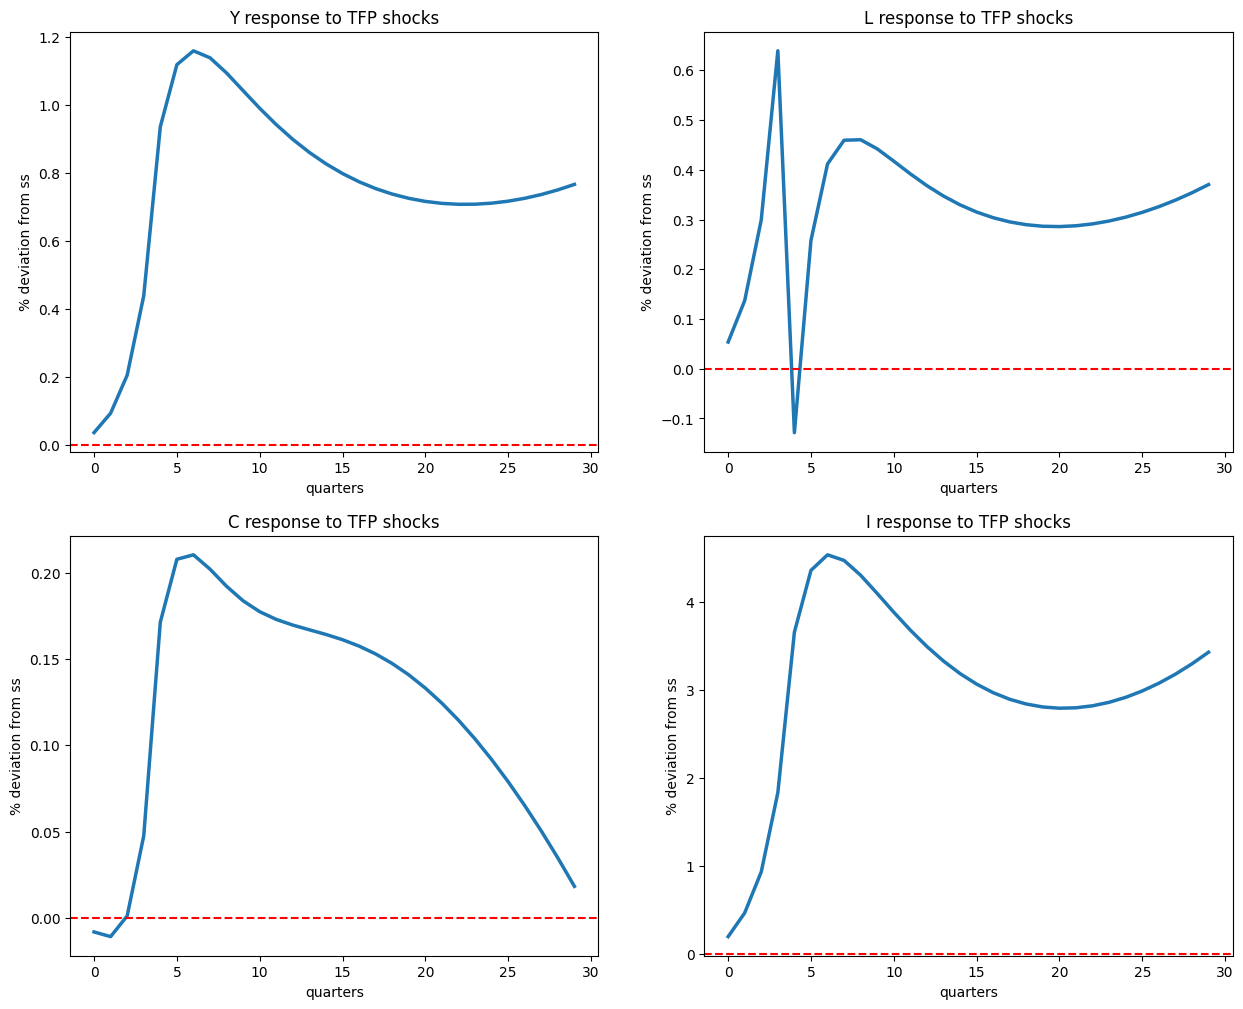

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)

for i in range(len(VAR_LIST)):
    var = VAR_LIST[i]
    dVal = 100 * G_3b[var]['epsilon_news'] @ deps_news / ss_3b[var]
    
    ax = plt.subplot(2, 2, i + 1)

    ax.plot(dVal[:30], linewidth=2.5)
    ax.axhline(y = 0, linestyle = "--", color = "r")
    ax.set_title(f'{var} response to TFP shocks')
    ax.set_ylabel('% deviation from ss')
    ax.set_xlabel('quarters')

plt.show()